In [6]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data

In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

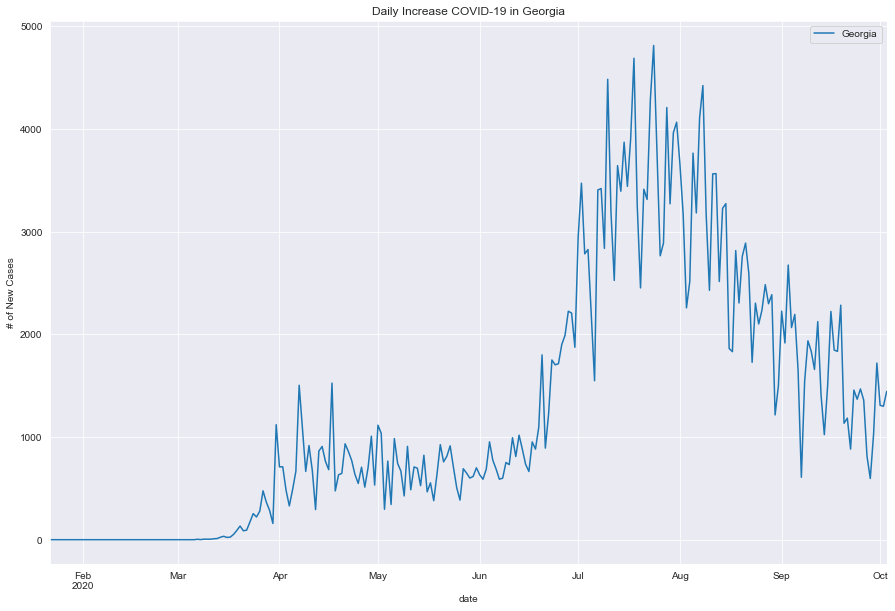

In [3]:
df = pd.read_csv('national_positive_increase.csv')

df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Georgia
ga = df['GA_positiveIncrease']
ga.plot(figsize=(15, 10), label='Georgia')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Georgia')
plt.legend()
plt.show();


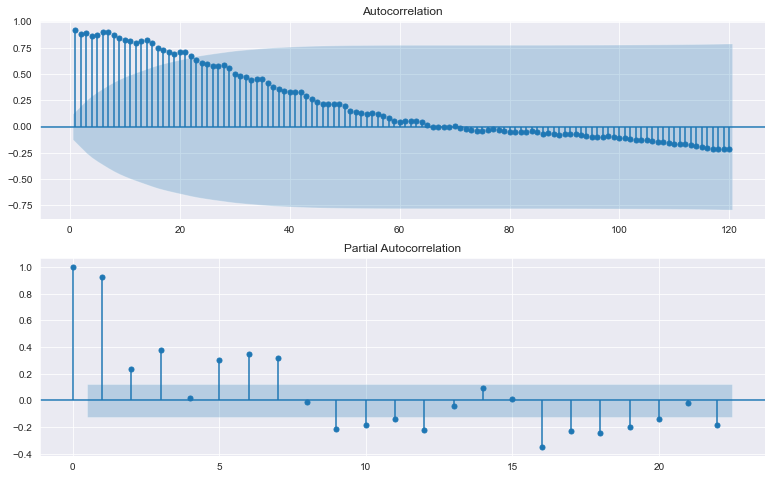

In [4]:
acf_pacf(ga)

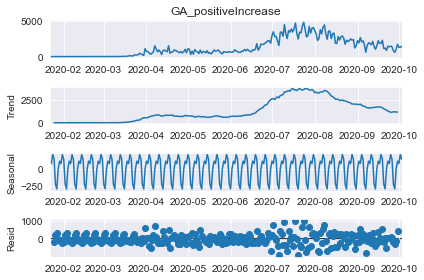

In [5]:
decompose_time_series(ga)

In [7]:
ga_results = pm.auto_arima(ga, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=4, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ga_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=3743.143, BIC=3764.391, Fit time=0.732 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=3877.888, BIC=3884.971, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=3838.104, BIC=3852.269, Fit time=0.227 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3795.912, BIC=3810.077, Fit time=0.373 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3794.228, BIC=3811.934, Fit time=0.516 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=3741.415, BIC=3766.204, Fit time=1.149 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 7); AIC=3749.280, BIC=3770.528, Fit time=0.649 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=3765.204, BIC=3793.534, Fit time=1.246 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=3777.824, BIC=3795.530, Fit time=0.428 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 1, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [9]:
ga_train, ga_test = train_test(ga)

                                      SARIMAX Results                                      
Dep. Variable:                 GA_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -1484.701
Date:                             Tue, 13 Oct 2020   AIC                           2983.403
Time:                                     14:50:32   BIC                           3006.630
Sample:                                 01-22-2020   HQIC                          2992.798
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8446      0.059    -14.260      0.000      -0.961      -0.729
ma.L1          0.2519      

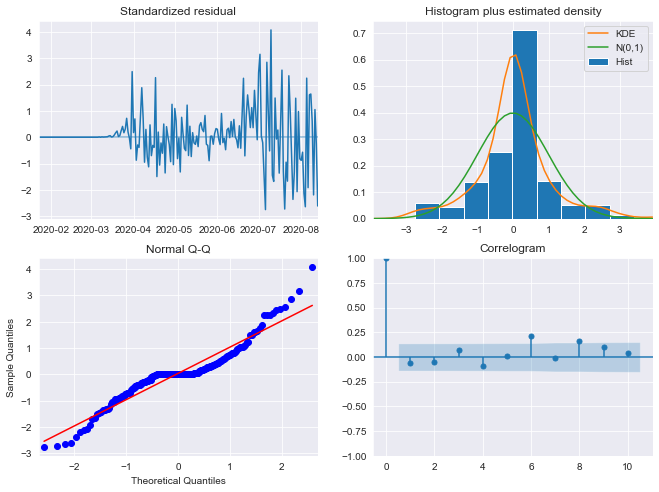

In [10]:
pdq = (1, 1, 2)
pdqs = (2, 0, 1, 7)
train, test, results = fit_model(ga_train, ga_test, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on test data: 359.50285


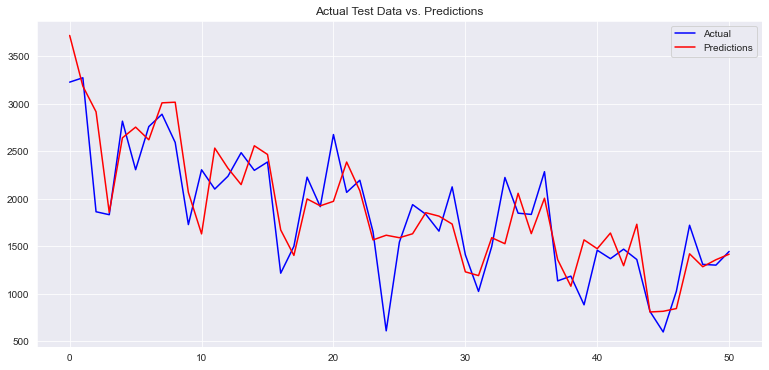

In [12]:
test_RMSE(ga_train, ga_test, pdq, pdqs, display=True)

SARIMA model RMSE on train data: 582.00243


<Figure size 936x432 with 0 Axes>

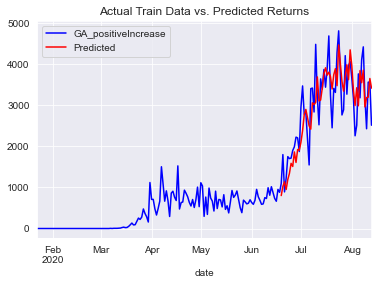

In [13]:
train_RMSE(ga_train, results, display = True)